In [750]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

#plt.style.use('dark_background')

In [751]:
# Another dataset is taken as a basis for regression!!!
df_full = pd.read_csv('data/airfoil_noise_data.csv', sep=',')

target = ['y']
features = ['x0', 'x1', 'x2', 'x3', 'x4']

df1 = df_full[features + target]
display(df1)

,x0,x1,x2,x3,x4,y
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


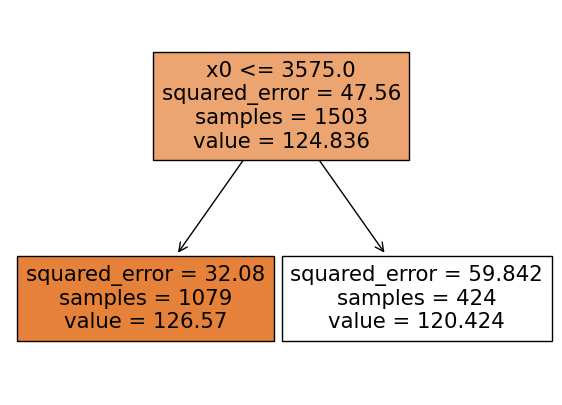

In [752]:
dt_regression = DecisionTreeRegressor(random_state=1, max_depth=1)
dt_regression.fit(df1[features], df1[target])

plt.figure(figsize=(7, 5))
plot_tree(dt_regression, feature_names=list(features), filled=True, impurity=True)
plt.show()

In [753]:
# Variance function
def dispersion(labels):
    mean_labels = np.mean(labels)
    return np.mean((labels - mean_labels)**2)

In [754]:
# Information Gain
def gain(left_labels, right_labels, root_criterion, criterion):
    p_left = left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0])
    p_right = 1 - p_left

    gain_result = root_criterion - p_left * criterion(left_labels) - p_right * criterion(right_labels)
    return gain_result

In [755]:
 class Node:
    def __init__(self, index, t, left_branch, right_branch):
        self.index = index
        self.t = t
        self.left_branch = left_branch
        self.right_branch = right_branch

In [756]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        prediction = np.mean(self.labels)  # name: value
        return prediction

In [757]:
# Split function by predicate
def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    left_data = data[left]
    right_data = data[right]
    left_labels = labels[left]
    right_labels = labels[right]

    return left_data, right_data, left_labels, right_labels

In [758]:
def find_best_split(data, labels):
    min_leaf = 5
    current_dispersion = dispersion(labels)

    best_information_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]  # e.g. 5 features

    # select every feature(col) by index
    for index in range(n_features):
        # unique values in select feature
        # Step 2 & so on => uses split features
        t_values = np.unique(data[:, index])

        # this values equate to threshold
        for t in t_values:
            # value of threshold inserted to split function; index shows feature
            left_data, right_data, left_labels, right_labels = split(data, labels, index, t)

            # exclude continuation of branches if their number of leaf < min_leaf
            if len(left_data) < min_leaf or len(right_data) < min_leaf:
                continue

            # growth => the more the better
            information_gain = gain(left_labels, right_labels, current_dispersion, dispersion)

            # finding the better value of gain
            if information_gain > best_information_gain:
                best_information_gain, best_t, best_index = information_gain, t, index

    return best_information_gain, best_t, best_index

In [759]:
# With max depth tree
def build_tree(data, labels, current_depth=0, max_depth=5):

    quality, t, index = find_best_split(data, labels)

    if quality == 0 or current_depth > max_depth:
        return Leaf(data, labels)

    left_data, right_data, left_labels, right_labels = split(data, labels, index, t)

    left_branch = build_tree(left_data, left_labels, current_depth + 1)
    right_branch = build_tree(right_data, right_labels, current_depth + 1)

    return Node(index, t, left_branch, right_branch)

In [760]:
def detect_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return detect_object(obj, node.left_branch)
    else:
        return detect_object(obj, node.right_branch)

In [761]:
def predict(data, tree):
    predictions = []
    for obj in data:
        prediction = detect_object(obj, tree)
        predictions.append(prediction)

    return predictions

In [762]:
X_train, X_test, y_train, y_test = train_test_split(df1[features].values,
                                                        np.squeeze(df1[target].values),
                                                        test_size=0.3,
                                                        random_state=1)

In [763]:
my_tree = build_tree(X_train, y_train)

In [764]:
# build train tree recursion
def print_tree(node, spacing=''):
    if isinstance(node, Leaf):
        print(spacing + 'Prediction', node.prediction)
        return

    print(spacing + 'Index', str(node.index))
    print(spacing + 'Threshold', str(node.t))

    print(spacing + '--> True:')
    print_tree(node.left_branch, spacing + '  ')

    print(spacing + '--> False:')
    print_tree(node.right_branch, spacing + '  ')

print_tree(my_tree, '||||||')

||||||Index 0
||||||Threshold 2500.0
||||||--> True:
||||||  Index 4
||||||  Threshold 0.0337792
||||||  --> True:
||||||    Index 3
||||||    Threshold 55.5
||||||    --> True:
||||||      Index 4
||||||      Threshold 0.0130253
||||||      --> True:
||||||        Index 2
||||||        Threshold 0.1524
||||||        --> True:
||||||          Index 0
||||||          Threshold 630.0
||||||          --> True:
||||||            Prediction 126.71065384615386
||||||          --> False:
||||||            Prediction 129.731345323741
||||||        --> False:
||||||          Index 0
||||||          Threshold 1250.0
||||||          --> True:
||||||            Prediction 127.64141584158415
||||||          --> False:
||||||            Prediction 122.63926086956522
||||||      --> False:
||||||        Index 0
||||||        Threshold 1250.0
||||||        --> True:
||||||          Index 0
||||||          Threshold 500.0
||||||          --> True:
||||||            Prediction 124.51433333333333
|||||| 

In [765]:
train_answers = predict(X_train, my_tree)
test_answers = predict(X_test, my_tree)

In [766]:
def r2(actual, predicted):
    R2 = round((1 - np.sum((actual - predicted)**2) / np.sum((np.mean(actual) - actual)**2)) * 100, 4)
    return R2

In [767]:
train_accuracy = r2(y_train, train_answers)
train_accuracy

74.6138

In [768]:
test_accuracy = r2(y_test, test_answers)
test_accuracy

61.7186